In [1]:
import pandas as pd

df_btc = pd.read_csv("./quotes.csv")
df_btc["timestamp"] = df_btc["timestamp"].apply(lambda x: x[:10])
print(df_btc["timestamp"])
df_btc = df_btc.astype({"timestamp": "datetime64[s]"}).set_index("timestamp")
df_btc.head()

0     2024-08-21
1     2024-08-22
2     2024-08-23
3     2024-08-24
4     2024-08-25
         ...    
95    2024-11-24
96    2024-11-25
97    2024-11-26
98    2024-11-27
99    2024-11-28
Name: timestamp, Length: 100, dtype: object


,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply
timestamp,,,,,,,,,,
2024-08-21,0,-0.259023,3.119146,3.822595,-9.291341,61220.255035,3.230223e+10,1.208683e+12,19743196,19743196
2024-08-22,1,-0.366595,-1.457215,4.719244,-8.518946,60328.144488,2.804668e+10,1.191099e+12,19743678,19743678
2024-08-23,2,-0.392219,6.412008,9.026376,-1.725949,64196.389701,4.164920e+10,1.267505e+12,19744178,19744178
2024-08-24,3,0.416369,-0.385213,7.679103,-2.732526,63949.097035,2.225770e+10,1.262655e+12,19744696,19744696
2024-08-25,4,0.251679,1.101118,8.943554,-4.825128,64653.252252,1.750459e+10,1.276586e+12,19745112,19745112


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

split_time = 80
time_train = df_btc.index[:split_time]
x_train = df_btc['price'][:split_time]
time_valid = df_btc.index[split_time:]
x_valid = df_btc['price'][split_time:]



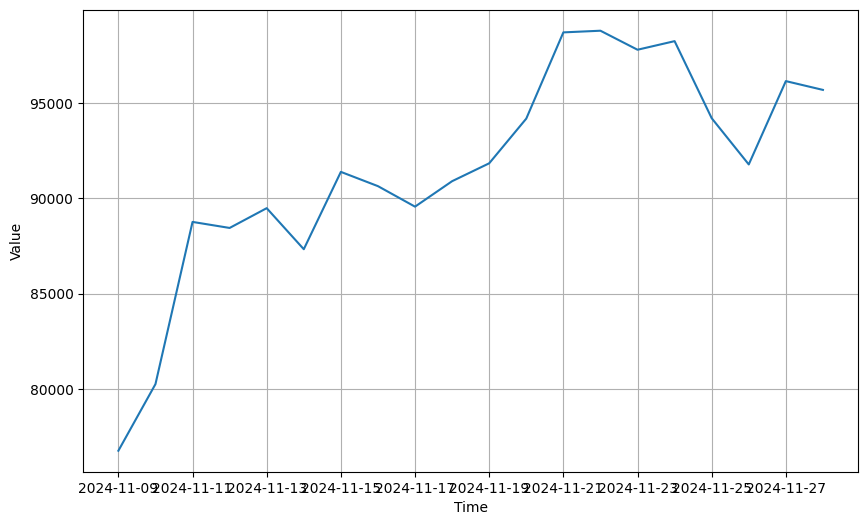

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)
#   return dataset

# window_size = 5
# batch_size = 10
# shuffle_buffer_size = 100
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# for features, labels in dataset:
#     print("Features:", features.numpy())
#     print("Labels:", labels.numpy())

In [5]:
import numpy as np

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_sequences(df_btc['price'], window_size)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X_train)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

[[61220.25503455 60328.14448821 64196.38970061 63949.09703459
  64653.25225174 62991.46571065 59313.13697208 59138.44316712
  59305.29681984 59206.43564603]
 [60328.14448821 64196.38970061 63949.09703459 64653.25225174
  62991.46571065 59313.13697208 59138.44316712 59305.29681984
  59206.43564603 58980.42616208]
 [64196.38970061 63949.09703459 64653.25225174 62991.46571065
  59313.13697208 59138.44316712 59305.29681984 59206.43564603
  58980.42616208 57546.95995723]
 [63949.09703459 64653.25225174 62991.46571065 59313.13697208
  59138.44316712 59305.29681984 59206.43564603 58980.42616208
  57546.95995723 59319.59893215]
 [64653.25225174 62991.46571065 59313.13697208 59138.44316712
  59305.29681984 59206.43564603 58980.42616208 57546.95995723
  59319.59893215 57738.98916195]
 [62991.46571065 59313.13697208 59138.44316712 59305.29681984
  59206.43564603 58980.42616208 57546.95995723 59319.59893215
  57738.98916195 58180.85699031]
 [59313.13697208 59138.44316712 59305.29681984 59206.43564

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_18020/16954114.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i + window_size])


In [6]:
# Tune hyperparameters

from kerastuner.tuners import RandomSearch

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(hp.Int('units', min_value=20, max_value=40, step=5), activation="relu", input_shape=(window_size, 1)))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.1, 0.5, 0.01])))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='models', project_name='btc')

tuner.search_space_summary()

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

tuner.results_summary()

Reloading Tuner from models/btc/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 5, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.5, 0.01], 'ordered': True}
Results summary
Results in models/btc
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 09 summary
Hyperparameters:
units: 35
learning_rate: 0.1
Score: 3181054.5833333335

Trial 13 summary
Hyperparameters:
units: 40
learning_rate: 0.1
Score: 3515716.0833333335

Trial 00 summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 6678869.25

Trial 03 summary
Hyperparameters:
units: 25
learning_rate: 0.01
Score: 7884356.0

Trial 04 summary
Hyperparameters:
units: 35
learning_rate: 0.01
Score: 8002652.166666667

Trial 14 summary
Hyperparameters:
units: 20
learning_rate: 0.01
Score: 8401675.5

Trial 11 summary
Hyperparameters:
units: 30
learning_rate: 0.01
Score

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_18020/3187651763.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [7]:
# Build model

import tensorflow as tf

optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(35,  activation="relu", input_shape=(window_size, 1)),  # LSTM layer
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32)
# history = model.fit(dataset, epochs=100, batch_size=32)

Epoch 1/100


/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2210571776.0000 - mae: 40400.3438  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2433512960.0000 - mae: 48462.4141 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3743864832.0000 - mae: 60919.6250 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1784756992.0000 - mae: 41547.2500
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 727807488.0000 - mae: 26490.2832 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 191105808.0000 - mae: 13190.0293 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 329409216.0000 - mae: 17788.7734 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2036435584.0000 - mae: 19470.2598
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 320314752.0000 - mae: 17349.4961
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 572591680.0000 - mae: 23730.9590 
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 193295744.0000 - mae: 12951.9736 
Epoch 

In [8]:
# import numpy as np

# forecast = []
# for time in range(len(df_btc['price']) - window_size):
#   forecast.append(model.predict(df_btc['price'][time:time + window_size]))

# forecast = forecast[split_time-window_size:]
# results = np.array(forecast)[:, 0, 0]


# plt.figure(figsize=(10, 6))

# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


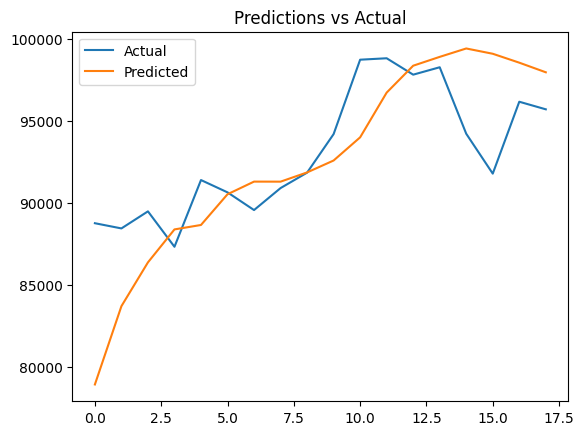

In [9]:
# Plot predictions against actual values

import matplotlib.pyplot as plt

predictions = model.predict(X_test)

plt.plot(y_test, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.title("Predictions vs Actual")
plt.show()